# Quantitatively comparing ensembles in IDPET

In this notebook, we are going use IDPET to quantitatively compare 3D structural ensembles.

We will analyze three PED ensembles of the drkN SH3 domain ([PED00156](https://proteinensemble.org/entries/PED00156), [PED00157](https://proteinensemble.org/entries/PED00157) and [PED00158](https://proteinensemble.org/entries/PED00158)). Please refer to the `sh3_example.ipynb` notebook for more information about these three ensembles.

Here, the goal is to illustrate in more detail the scores for comparing ensembles in IDPET.

## Part 1: setting up

### Load ensembles

We begin by loading the three ensembles as usual in IDPET. We will directly download them from PED.

In [1]:
import sys
sys.path.append('/home/hamid/Desktop/Ensemble_tool/EnsembleTools')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from dpet.ensemble_analysis import EnsembleAnalysis
from dpet.ensemble import Ensemble
from dpet.visualization import plot_comparison_matrix, Visualization


ensembles = [
    Ensemble(code='PED00156e001', database='ped'),
    Ensemble(code='PED00157e001', database='ped'),
    Ensemble(code='PED00158e001', database='ped')
]
data_dir = '/home/hamid/PED_Data_analysis/nikola'

analysis = EnsembleAnalysis(ensembles, data_dir)
analysis.load_trajectories()

/home/hamid/anaconda3/envs/ped/lib/python3.11/site-packages/neo_force_scheme/distances.py:1086: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()


Ensemble PED00156e001 already downloaded. Skipping.
File PED00156e001.pdb already exists. Skipping extraction.
Trajectory file already exists for ensemble PED00156e001.
Ensemble PED00157e001 already downloaded. Skipping.
File PED00157e001.pdb already exists. Skipping extraction.
Trajectory file already exists for ensemble PED00157e001.
Ensemble PED00158e001 already downloaded. Skipping.
File PED00158e001.pdb already exists. Skipping extraction.
Trajectory file already exists for ensemble PED00158e001.
Loading trajectory for PED00156e001...
Loading trajectory for PED00157e001...
Loading trajectory for PED00158e001...


{'PED00156e001': <mdtraj.Trajectory with 100 frames, 941 atoms, 59 residues, without unitcells at 0x726a979fc710>,
 'PED00157e001': <mdtraj.Trajectory with 100 frames, 939 atoms, 59 residues, without unitcells at 0x726a97efd390>,
 'PED00158e001': <mdtraj.Trajectory with 88 frames, 939 atoms, 59 residues, without unitcells at 0x726a97d36650>}

### Summary table

Before starting the analysis, let's use the `get_features_summary_dataframe()` method to obtain a summary of information on the ensembles.

We can look at the number of residues and number of conformers, as well as some useful global descriptors (such as radius-of-gyration).

All ensembles of this IDP have a similar average radius-of-gyration. By using more complex comparison methods we will see that the three ensembles actually have significant differences.

In [3]:
analysis.get_features_summary_dataframe(
    selected_features=["rg", "asphericity", "end_to_end"],
    show_variability=False
)

,ensemble_code,n_residues,n_conformers,rg_mean,asphericity_mean,end_to_end_mean
0,PED00156e001,59,100,1.793522,0.367338,4.334907
1,PED00157e001,59,100,1.908008,0.480395,4.339479
2,PED00158e001,59,88,1.867024,0.527425,4.378268


### Setting up a visualization object

There are several ways in which we can perform quantitative ensemble comparisons in IDPET.

The easiest way is via the `visualization` module. We will begin by using this strategy.

Later, in **Part 5** of this notebook, we will see how to use a lower-level API to have more control or to perform comparisons in your custom Python scripts.

In [3]:
vis = Visualization(analysis)  # Initializes a Visualization object for the analysis.

## Part 2 (preliminary analysis): qualitive comparisons of molecular features

In IDPET, the quantitative methods for comparing ensembles work in a simple way. They look at the distributions of two types of molecular features:

* distribution of pairwise $C\alpha$-$C\alpha$ distances,
* joint distribution of $\phi$ and $\psi$ backbone torsion angles.

When making a comparison, the methods attempt to score the divergence between ensembles based on the distribution of these features.

Before performing the actual scoring, let’s first visualize the actual distributions of these features using histograms and scatter plots. 

This qualitative analysis will be useful to better makes sense of the numerical scores later on.

### $C\alpha$-$C\alpha$ distances

First, let’s plot histograms of $C\alpha$-$C\alpha$ distances between some random residues.

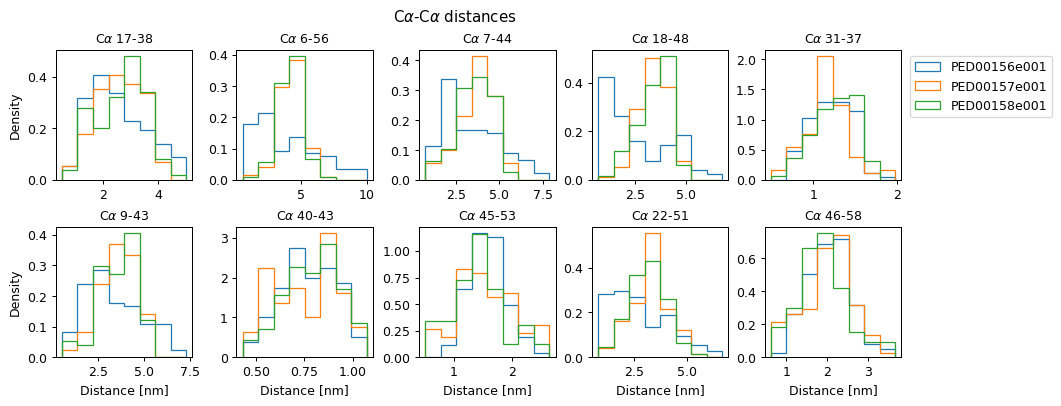

In [5]:
np.random.seed(2024)  # Set a random seed for reproducibility.
n_bins = 8

vis.plot_histogram_grid(
    feature="ca_dist",
    n_rows=2,
    n_cols=5,
    bins=n_bins
);
    

The ensembles are from the same disordered protein, so their histograms appear as similar. This is why performing a quantitative analysis will help.

Despite their similarity, we can spot some differences by eye: the distributions of PED00157 and PED00158 appear as more closely related to each other with respect to PED00156 (e.g.: see distance between residue index 6-56 and 18-48).

**Note**: in this notebook, residue numbering always starts from zero.

### $\phi$ and $\psi$ angles

Now, let’s plot some [Ramachandran plots](https://en.wikipedia.org/wiki/Ramachandran_plot) showing $\phi$ and $\psi$ angles of different residues. In this case, the differences are more evident (PED00156 looks more different with respect to the other two ensembles) and we will see how comparison scores reflect this.

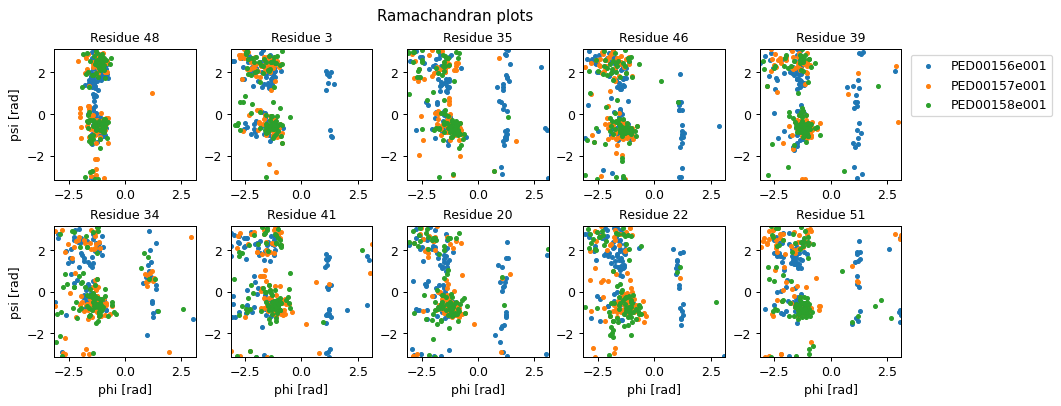

In [6]:
np.random.seed(1) # 1

vis.plot_rama_grid(
    n_rows=2,
    n_cols=5,
);

## Part 3: comparing ensembles with scores based on Jensen-Shannon divergence

Let's start the actual comparison. We will begin by using the a series of scores based on approximations of [Jensen-Shannon divergence](https://en.wikipedia.org/wiki/Jensen–Shannon_divergence) (JSD) between probability distributions.

We will use two scores:
- `adaJSD`: compares at distributions of pairwise $C\alpha$-$C\alpha$ distances.
- `ramaJSD`: compares joint distributions of $\phi$ and $\psi$ torsion angles.

the lower these scores are, the more similar two ensembles are. A score of 0 means that two ensembles have identical distributions. The theoretical maximum value is $log(2) \approx 0.6931$, corresponding to two ensembles with distributions with zero overlap. You can find details about these scores in the [IDPET manuscript](https://en.wikipedia.org/wiki/Jensen–Shannon_divergence).

By using the `comparison_matrix()` method of the `Visualization` class, we can easily perform an all-vs-all comparison between all the ensembles we are analyzing.


# Scoring 'jsd' using features 'ca_dist'
num_bins: 10
- Number of bins for all comparisons: 10
- We have 3 pairs of ensembles and will perform a total of 3 comparisons.
# Scoring 'jsd' using features 'rama'
num_bins: 10
- Number of bins for all comparisons: 10
- We have 3 pairs of ensembles and will perform a total of 3 comparisons.
# Scoring 'jsd' using features 'alpha_angle'
num_bins: 10
- Number of bins for all comparisons: 10
- We have 3 pairs of ensembles and will perform a total of 3 comparisons.


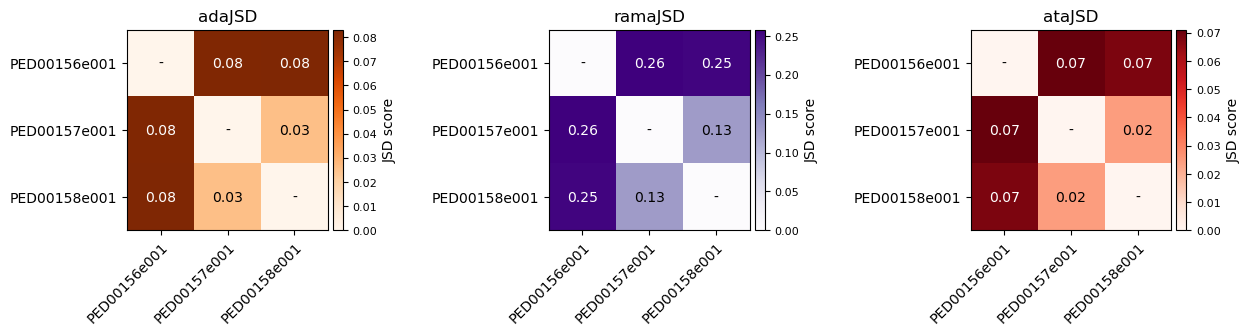

In [5]:
bins = "auto"

# Create a figure with two panels.
fig, ax = plt.subplots(1, 3, figsize=(13, 8))

# Plot on the left panel all-vs-all adaJSD scores (compare Ca-Ca distances).
vis.comparison_matrix(
    score="adaJSD",
    bins=bins,
    ax=ax[0],
    cmap="Oranges",
    verbose=True
)

# Plot on the right panel all-vs-all ramaJSD scores (compare phi/psi angles).
vis.comparison_matrix(
    score="ramaJSD",
    bins=bins,
    ax=ax[1],
    cmap="Purples",
    verbose=True
)

vis.comparison_matrix(
    score="ataJSD",
    bins=bins,
    ax=ax[2],
    cmap="Reds",
    verbose=True
)



plt.tight_layout(pad=2.5)
plt.show()

The scores in the heatmap confirm our initial observations.

Based on $C\alpha$-$C\alpha$ distance distributions (heatmap on the left), PED00157 and PED00158 are more similar to each other with respect to PED00156.

The comparison shows that the same trend appears to exists also for $\phi$ and $\psi$ angles distributions (heatmap on the right).

**NOTE**: We set the `bins` argument to `auto`. In IDPET, the JSD-based scores require discretizing data in histograms. The values of `bins` can influence the results. Unless there is a specific reason to change it, the safest option is to use the `auto` argument to let IDPET figure out the optimal number of bins. By using this value, the number of bins will be selected using the [square root rule](https://en.wikipedia.org/wiki/Histogram#Square-root_choice) based on the minimum number of conformers in the ensembles under comparison, but if the minimum number of conformers is > 2500, the number of bins will be set to a maximum of 50.

### Comment 1: how to select a score for comparing ensembles in IDPET?

Comparing structural ensembles of proteins is a challenging task. Like most ensemble comparison methods, the scores implemented in IDPET are not a perfect solution. Firstly, they consider only monodimensional or bidimensional distributions of features and don't look at higher-order joint distributions: adaJSD computes a JSD approximation over lots of pairs of $C\alpha$-$C\alpha$ distances and then averages them, and ramaJSD computes JSD approximations of Ramachandran features of each residue and then takes the average. Secondly, they only look at specific atoms: adaJSD looks at $C\alpha$ atoms only and ramaJSD looks at backbone atoms only.

Nevertheless they can provide useful information.

Which score should you normally use to compare your ensembles in IDPET? Here are some tips:

- adaJSD is the best candidate for comparing the "global" properties of proteins. It captures both short and long-range geometrical properties of $C\alpha$ atoms. If you want to use only one score in IDPET, this is probably the best choice.
- ramaJSD is specific to backbone geometries. Use it to assess specifically the local backbone structural properties the ensembles. Sometimes ensembles can have very similar global properties, but very different local ones. This score provides complementary information to adaJSD.
- **IMPORTANT**: when your ensembles are very small (less than 25-50 conformers), any of these scores will tend to fail at capturing existing differences. Use them with caution in these situations or try to use a statistical approach (see below).

### Comment 2: ataJSD as an alternative to ramaJSD for coarse-grained ensembles
The ramaJSD score can be used to compare the local backbone properties of ensemble by looking at $\phi$ and $\psi$ angles. But what if you are working with coarse-grained ensembles that contain only $C\alpha$ atoms so that such angles cannot be calculated? This is a common situation in IDP modeling research.

IDPET implements the ataJSD score to compare local properties of coarse-grained ensembles. This score compares the distributions of $\alpha$ torsion angles, that is, the torsions between four consecutive $C\alpha$ atoms in a protein. You can use it on coarse-grained ensembles or on all-atom ensembles if you want to look at more coarse-grained properties of backbones.

To illustrate how it works, let's first plot some histograms with $\alpha$ torsion angles.

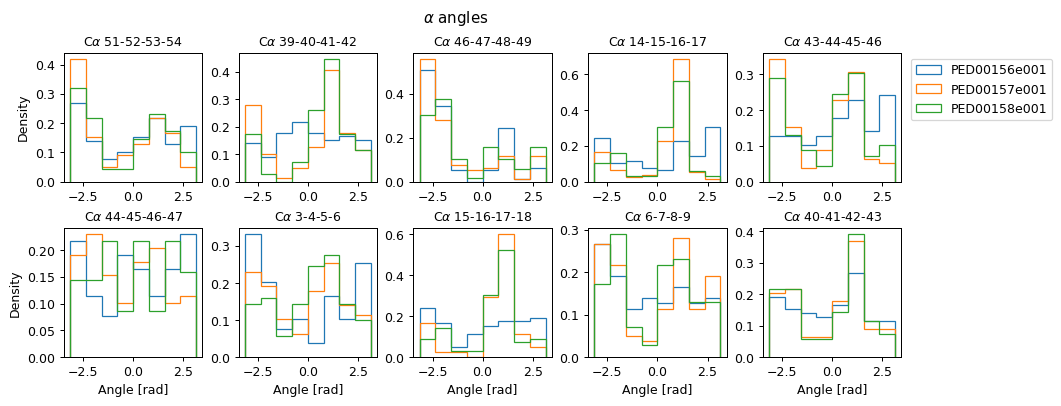

In [8]:
np.random.seed(2024)

vis.plot_histogram_grid(
    feature="a_angle",
    n_rows=2,
    n_cols=5,
    bins=n_bins
);

Now let's perform an all-vs-all comparison with ataJSD.

# Scoring 'jsd' using features 'alpha_angle'
num_bins: 10
- Number of bins for all comparisons: 10
- We have 3 pairs of ensembles and will perform a total of 3 comparisons.


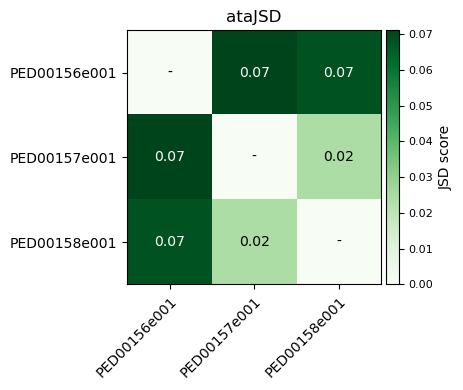

In [6]:
bins = "auto"

# Create a figure with two panels.
fig, ax = plt.subplots(1, 1, figsize=(5.0, 4))

# Plot on the right panel all-vs-all ataJSD scores (compare alpha torsion angles).
vis.comparison_matrix(
    score="ataJSD",
    bins=bins,
    ax=ax,
    cmap="Greens",
    verbose=True
)

plt.tight_layout()
plt.show()

## Part 4: bootstrapping and statistical significance

The previous analysis outlined the relationships between the ensembles.

But are the results statistically significant? Those ensembles are quite small for a disordered protein: 100 or less conformers. Would the results change if we were to add or remove conformers?

To answer this question, we can perform a statistical analysis via bootstrapping. Just provide a `bootstrap_iters` argument to the `comparison_matrix()` method.

**Confidence intervals**

IDPET will perform the following analysis:
- Compare each pair of ensembles `bootstrap_iters` times, each time by subsampling conformers via bootstrapping. The scores in the heatmap are now confidence intervals in the form of `[lower, higher]`, estimated via boostrapping. The smaller (or sparser) an ensemble is, the larger the uncertainty should be.
- Compare each ensemble with itself by subsampling conformers with bootstrapping. Note how the diagonal of the heatmap also contains some values now. Those are the confidence levels for these auto-comparison scores.

**Statistical test**

A key question is: are the inter-ensemble scores (comparison of different ensembles) significantly higher than intra-ensemble scores (auto-comparisons)? In other words: is the divergence between ensemble $i$ and $j$ really higher than the one between different subsamples from ensemble $i$ (or $j$)?

To answer this question, IDPET uses the following strategy:
- For each ensemble pair $i$ and $j$, get the comparison scores obtained in bootstrapping, called the inter-ensemble scores.
- Get the bootstrapping scores from auto-comparisons of both ensemble $i$ and $j$. The scores with the higher mean are selected as our reference intra-ensemble scores.
- Compare the inter-ensemble and intra-ensemble scores via a one-sided [Mann-Whitney U test](https://en.wikipedia.org/wiki/Mann–Whitney_U_test). The alternative hypothesis is: inter-ensemble scores are stochastically greater than intra-ensemble scores. If the null hypothesis (no difference) is rejected, an asterisk `*` will be shown beside the intervals in the heatmap.

In our example, it looks like that PED00157 and PED00158 have low adaJSD scores, but these scores appear to be significantly higher than those obtained by auto-comparisons, hinting at a systematic difference.

# Scoring 'jsd' using features 'ca_dist'
num_bins: 10
- Number of bins for all comparisons: 10
- We have 6 pairs of ensembles and will perform a total of 300 comparisons.


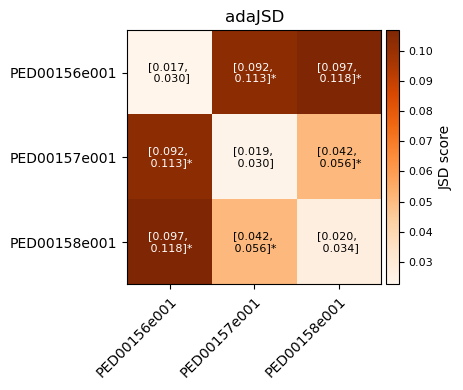

In [7]:
# Parameters.
bootstrap_iters = 25  # The more iterations, the better, but it will take more time.
bins = "auto"

# Create a figure with one panel.
fig, ax = plt.subplots(1, 1, figsize=(5.0, 4))

# Plot on the panel all-vs-all adaJSD scores (compare Ca-Ca distances).
vis_out = vis.comparison_matrix(
    score="adaJSD",
    bootstrap_iters=bootstrap_iters,
    bins=bins,
    ax=ax,
    cmap="Oranges",
    verbose=True,
    confidence_level=0.95,   # For confidence intervals shown in the plot.
    significance_level=0.05  # For the Mann-Whitney U test.
)

plt.tight_layout()
plt.show()

**NOTE**: this bootstrap analysis largely increases computational times. Use it only when you have a few ensembles and when those ensembles have a small number of conformers (less than 100). For larger ensembles, comparison scores in IDPET tend to be more robust.

## Part 5: low-level usage of comparison functions

In this last part, we will introduce another strategy to use comparison scores in IDPET. We will not directly use the `Visualization` class here, rather we will use more low-level functions.

First, let's import the necessary functions.

In [10]:
from dpet.comparison import (
    score_adaJSD, get_adaJSD_matrix,
    score_ataJSD, get_ataJSD_profile,
    score_avg_jsd,
    score_ramaJSD, get_ramaJSD_profile,
    all_vs_all_comparison,
    process_all_vs_all_output
)

Then, get the ensembles to compare. We will compare there PED00156e001 and PED00157e001.

In [18]:
ens_1 = analysis["PED00156e001"]
ens_2 = analysis["PED00157e001"]
ens_3 = analysis["PED00158e001"]

### Computing JSD-based scores

Easy, quick way to compute adaJSD, ataJSD and ramaJSD.

In [19]:
score, bins = score_adaJSD(ens_1, ens_2, bins="auto", return_bins=True)
print(f"- adaJSD score: {score:.4f}, bins used: {bins}")

score, bins = score_ataJSD(ens_1, ens_2, bins="auto", return_bins=True)
print(f"- ataJSD score: {score:.4f}, bins used: {bins}")

score, bins = score_ramaJSD(ens_1, ens_2, bins=5, return_bins=True)
print(f"- ramaJSD score: {score:.4f}, bins used: {bins}")

- adaJSD score: 0.0825, bins used: 10
- ataJSD score: 0.0711, bins used: 10
- ramaJSD score: 0.1562, bins used: 5


Note how you can also provide as input to the functions `mdtraj` trajectories. This is helpful if you use `mdtraj` in your scripts and want to use IDPET to perform ensemble comparison with no visualization.

In [20]:
# We get mdtraj trajectories for the ensembles.
traj_1 = ens_1.trajectory
print("Input to score_adaJSD:", traj_1)

traj_2 = ens_2.trajectory
print("Input to score_adaJSD:", traj_2)

# score_adaJSD can take as input mdtraj objects.
score, bins = score_adaJSD(traj_1, traj_2, bins="auto", return_bins=True)
print(f"- adaJSD score: {score:.4f}, bins used: {bins}")
# Also other comparison methods take as input mdtraj trajectories.

Input to score_adaJSD: <mdtraj.Trajectory with 100 frames, 941 atoms, 59 residues, without unitcells>
Input to score_adaJSD: <mdtraj.Trajectory with 100 frames, 939 atoms, 59 residues, without unitcells>
- adaJSD score: 0.0825, bins used: 10


There is also a more complex way to compute average JSD values for `F` monodimensional distributions, which requires you to manually provide a `(N, F)` feature matrix. We only show how to do it for ataJSD (adaJSD is similar).

You can adapt it for any feature matrix of shape `(N, F)` and score any custom molecular feature.

You can also implement your own bootstrapping strategy with this system.

In [21]:
# Manually compute features (alpha_angles).
alpha_1 = ens_1.get_features(featurization="a_angle")
print("- features 1 shape:", alpha_1.shape)
alpha_2 = ens_2.get_features(featurization="a_angle")
print("- features 2 shape:", alpha_2.shape)

# Manually compute average JSD approximation. You can also provide any other
# 2d feature matrix as input to the `score_avg_jsd` function.
score, bins = score_avg_jsd(alpha_1, alpha_2, limits="a", bins="auto", return_bins=True)
print(f"- ataJSD score: {score:.4f}, bins used: {bins}")

- features 1 shape: (100, 56)
- features 2 shape: (100, 56)
- ataJSD score: 0.0711, bins used: 10


### Performing a bootstrap analysis with lower-level API.

In case you want to perform the statistical analysis illustrated above. We will use two ensembles here. The `all_vs_all_comparison()` function allows us to perform the boostrap analysis by setting the `bootstrap_iters` argument. `all_vs_all_comparison()` is the same function used by the This is the `Visualization.comparison_matrix()` method we used above, but this time we are directly making use of it, without creating any plots.

In [22]:
# Perform bootstrap analysis on the two ensembles using adaJSD. 
comparison_out  = all_vs_all_comparison(
    ensembles=[ens_1, ens_2],
    score="adaJSD",
    bootstrap_iters=10,
    bins="auto"
)
# We can optionally use calculate boostrap confidence intervals.
comparison_out = process_all_vs_all_output(comparison_out)

# Print the results of the analysis.
intra_comparison_scores = comparison_out["scores"][0,0]
intra_comparison_ci = comparison_out["confidence_intervals"][0,0]
inter_comparison_scores = comparison_out["scores"][0,1]
inter_comparison_ci = comparison_out["confidence_intervals"][0,1]
inter_comparison_p_value = comparison_out["p_values"][0,1]
print(f"Mean intra-comparison score: {intra_comparison_scores.mean():.4f}")
print(f"Confidence intervals for intra-comparison score: [{intra_comparison_ci[0]:.4f}, {intra_comparison_ci[1]:.4f}]")
print(f"Mean inter-comparison score: {inter_comparison_scores.mean():.4f}")
print(f"Confidence intervals for inter-comparison score: [{inter_comparison_ci[0]:.4f}, {inter_comparison_ci[1]:.4f}]")
print(f"Inter-comparison score p-value: {inter_comparison_p_value}")


num_bins: 10
Mean intra-comparison score: 0.0225
Confidence intervals for intra-comparison score: [0.0187, 0.0282]
Mean inter-comparison score: 0.1028
Confidence intervals for inter-comparison score: [0.0949, 0.1111]
Inter-comparison score p-value: 9.133589555477501e-05


### Rationalizing JSD-based scores

Finally, IDPET allows you to analyze the results obtained by comparing two ensembles with adaJSD, ataJSD and ramaJSD.

All these scores compute JSD approximations for molecular features belonging to different residues (or group of residues) and then averages them.

While an average score can provide useful information, looking at the pattern of individual JSD scores can help making better sense of the differences between two ensembles.

Via the `get_adaJSD_matrix()` function you can access the raw scores for each $C\alpha$-$C\alpha$ distance. Use the `plot_jsd_d_matrix()` function to plot them.

Similarly, the `get_ramaJSD_profile()`, `get_ataJSD_profile()` functions return scores for each angle. We will only look at ataJSD scores here. Use the `plot_jsd_t_profile()` to plot them.

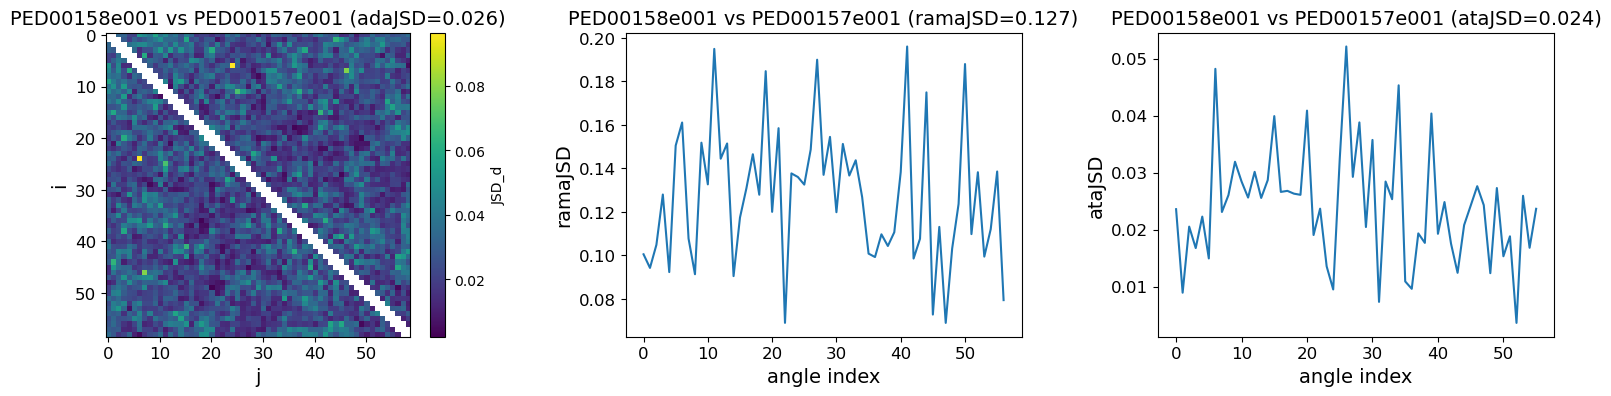

In [53]:
def plot_jsd_matrix(ens_3, ens_2, ax):
    # Compute JSD-based scores.
    avg_score, score_matrix = get_adaJSD_matrix(
        ens_3, ens_2, bins="auto", return_bins=False
    )
    # Plot.
    ax.set_title(f"{ens_3.code} vs {ens_2.code} (adaJSD={avg_score:.3f})", fontsize=14)
    im = ax.imshow(score_matrix)
    ax.set_xlabel("j")
    ax.set_ylabel("i")
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.set_label("JSD_d")
    ax.set_xlabel("j", fontsize=14)
    ax.set_ylabel("i", fontsize=14)
    return ax


def plot_jsd_profile(ens_3, ens_2, ax, score_name):
    # Compute JSD-based scores.
    if score_name == "ataJSD":
        avg_score, score_profile = get_ataJSD_profile(
            ens_3, ens_2, bins="auto", return_bins=False
        )
    elif score_name == "ramaJSD":
        avg_score, score_profile = get_ramaJSD_profile(
            ens_3, ens_2, bins="auto", return_bins=False
        )
    else:
        raise KeyError(score_name)
    
    # Plot.
    ax.set_title(f"{ens_3.code} vs {ens_2.code} ({score_name}={avg_score:.3f})", fontsize=14)
    im = ax.plot(score_profile)
    ax.set_xlabel("angle index")
    ax.set_ylabel(score_name)
    ax.set_xlabel("angle index", fontsize=14)
    ax.set_ylabel(score_name, fontsize=14)

    return ax


fig, ax = plt.subplots(1, 3, figsize=(16, 4.6))

jsd_prof = plot_jsd_profile(ens_3, ens_2, ax[2], "ataJSD")
jsd_prof_rama = plot_jsd_profile(ens_3, ens_2, ax[1], "ramaJSD")
matrix = plot_jsd_matrix(ens_3, ens_2, ax[0])
jsd_prof.tick_params(axis='both', labelsize=12)
jsd_prof_rama.tick_params(axis='both', labelsize=12)
matrix.tick_params(axis='both', labelsize=12)

plt.tight_layout(pad=3)
plt.show()


The higher a JSD score is, the higher the divergence between two distributions.

Clearly, the differences in $C\alpha$-$C\alpha$ distances and $\alpha$ angles of PED00156 and PED00157 are localized to specific regions. For examples, the most divergent $C\alpha$-$C\alpha$ distributions are the ones between residues an N-terminal patch of residues (~0-20) and a C-terminal patch (~45-58).

Let's confirm this by plotting some histograms of $C\alpha$-$C\alpha$ distances and $\alpha$ angles, specifically for those residues having high individual JSD scores.

The histograms reflect a difference in distributions between PED00156 and PED00157.

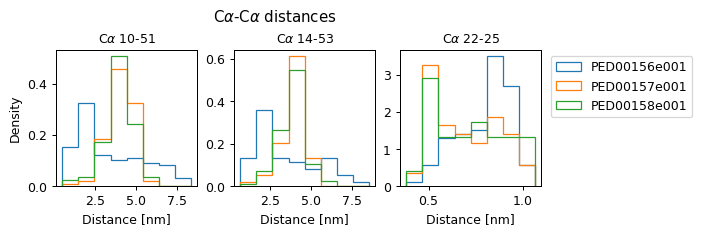

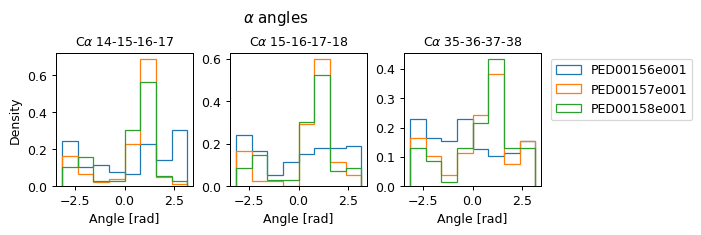

In [18]:
n_bins = 8

vis.plot_histogram_grid(
    feature="ca_dist",
    n_rows=1,
    n_cols=3,
    ids=[[10, 51], [14, 53], [22, 25]],  # Residue pairs appearing to have high JSD_d scores.
    bins=n_bins,
    subplot_width=2.0,
    subplot_height=2.5
);

vis.plot_histogram_grid(
    feature="a_angle",
    n_rows=1,
    n_cols=3,
    ids=[14, 15, 35],  # Residue indices appearing to have high JSD_t scores.
    bins=n_bins,
    subplot_width=2.0,
    subplot_height=2.5
);

The results from this analysis point at well-defined differences between PED00156 and PED00157. They could be used to drive an analysis of 3D conformers to directly visualize the structural differences in the ensembles.